In [40]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import resample, shuffle
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.utils import to_categorical

In [41]:
data = pd.read_csv("C:/Users/Akif/Desktop/football/rankingv5v2.csv")

In [42]:
data.shape

(18071, 40)

In [43]:
home_win = data[data['result'] == 1]
away_win = data[data['result'] == 2]
draw = data[data['result'] == 0]

In [44]:
draw_upsampled = resample(draw, replace=True, n_samples=len(home_win), random_state=42)
away_win_upsampled = resample(away_win, replace=True, n_samples=len(home_win), random_state=42)

In [45]:
data_balanced = pd.concat([home_win, draw_upsampled, away_win_upsampled])
data_balanced = shuffle(data_balanced, random_state=42)

In [46]:
print(data_balanced['result'].value_counts())

2    8159
0    8159
1    8159
Name: result, dtype: int64


In [47]:
data = data_balanced

In [48]:
selected_columns = [
    'home_club_id', 'away_club_id', 'attendance', 'result', 'home_team_points', 'away_team_points',
       'home_attack_value', 'away_attack_value',
        'home_midfield_value',
       'away_midfield_value',  'home_defender_value',
       'away_defender_value', 
       'home_goalkeeper_value',
       'away_goalkeeper_value', 
       'home_total_market_value', 'away_total_market_value',
       'home_power_score', 'away_power_score'
]
data = data[selected_columns]


In [49]:
result_counts = data['result'].value_counts()
print("Class distribution in 'result' column:")
print(result_counts)

Class distribution in 'result' column:
2    8159
0    8159
1    8159
Name: result, dtype: int64


In [50]:
X = data.drop('result', axis=1)
y = data['result']

scaler = StandardScaler()
X = scaler.fit_transform(X)

encoder = OneHotEncoder(sparse_output=False)
y = encoder.fit_transform(y.values.reshape(-1, 1))

In [51]:
X, y = shuffle(X, y, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [52]:
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [53]:
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/30
574/574 [==============================] - 4s 5ms/step - loss: 1.2848 - accuracy: 0.4138 - val_loss: 1.0231 - val_accuracy: 0.4722
Epoch 2/30
574/574 [==============================] - 2s 4ms/step - loss: 1.0486 - accuracy: 0.4545 - val_loss: 1.0193 - val_accuracy: 0.4748
Epoch 3/30
574/574 [==============================] - 2s 4ms/step - loss: 1.0263 - accuracy: 0.4678 - val_loss: 1.0171 - val_accuracy: 0.4686
Epoch 4/30
574/574 [==============================] - 2s 4ms/step - loss: 1.0219 - accuracy: 0.4694 - val_loss: 1.0148 - val_accuracy: 0.4725
Epoch 5/30
574/574 [==============================] - 3s 6ms/step - loss: 1.0206 - accuracy: 0.4718 - val_loss: 1.0162 - val_accuracy: 0.4729
Epoch 6/30
574/574 [==============================] - 2s 4ms/step - loss: 1.0174 - accuracy: 0.4784 - val_loss: 1.0139 - val_accuracy: 0.4763
Epoch 7/30
574/574 [==============================] - 4s 6ms/step - loss: 1.0189 - accuracy: 0.4761 - val_loss: 1.0121 - val_accuracy: 0.4781
Epoch 

In [54]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

192/192 [==============================] - 0s 2ms/step


In [55]:
print(classification_report(y_true_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       0.43      0.34      0.38      2055
           1       0.51      0.59      0.55      2074
           2       0.53      0.57      0.55      1991

    accuracy                           0.50      6120
   macro avg       0.49      0.50      0.49      6120
weighted avg       0.49      0.50      0.49      6120



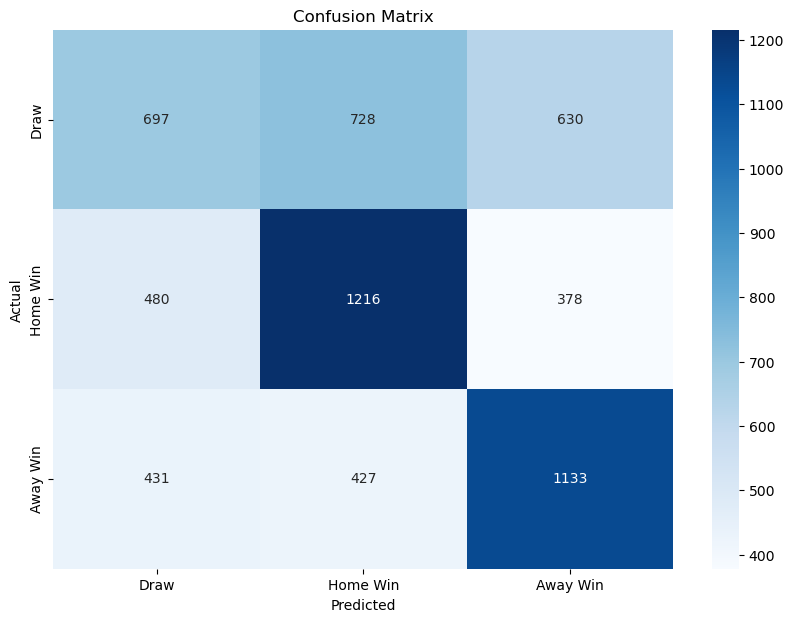

In [56]:
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Draw', 'Home Win', 'Away Win'], yticklabels=['Draw', 'Home Win', 'Away Win'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
def get_team_stats(team_id, data):
    team_data = data[(data['home_club_id'] == team_id) | (data['away_club_id'] == team_id)]
    team_avg_stats = team_data.mean()
    return team_avg_stats.drop(['home_club_id', 'away_club_id', 'result'])

In [ ]:
def predict_match(model, home_team_id, away_team_id, scaler, data):
    home_stats = get_team_stats(home_team_id, data)
    away_stats = get_team_stats(away_team_id, data)
    
    # Combine home and away team stats
    combined_stats = np.concatenate((home_stats, away_stats))
    
    # Ensure correct order and structure
    feature_columns = data.columns.drop(['home_club_id', 'away_club_id', 'result'])
    combined_stats_df = pd.DataFrame([combined_stats], columns=list(feature_columns) + list(feature_columns))
    
    # Standardize the features
    combined_stats = scaler.transform(combined_stats_df.values)
    
    # Predict
    prediction = model.predict(combined_stats)
    return prediction

In [ ]:
home_team_id = 3008
away_team_id = 148
prediction = predict_match(model, home_team_id, away_team_id, scaler, data)
print(f'Prediction: {prediction}')

In [ ]:
def predict_match(model, match_features, scaler):
    
    match_features_scaled = scaler.transform(match_features)
    prediction = model.predict(match_features_scaled)
    return prediction

new_match_features = pd.DataFrame([{
    'home_club_id': 3008,
    'away_club_id': 148,
    'attendance': 50000,
    'home_team_points': 65,
    'away_team_points': 70,
    'home_attack_value': 75,
    'home_attack_count': 100,
    'away_attack_value': 80,
    'away_attack_count': 110,
    'home_midfield_value': 70,
    'home_midfield_count': 95,
    'away_midfield_value': 72,
    'away_midfield_count': 90,
    'home_defender_value': 78,
    'home_defender_count': 110,
    'away_defender_value': 75,
    'away_defender_count': 100,
    'home_goalkeeper_value': 80,
    'home_goalkeeper_count': 30,
    'away_goalkeeper_value': 78,
    'away_goalkeeper_count': 35,
    'home_total_market_value': 300000000,
    'away_total_market_value': 250000000,
    'home_power_score': 78,
    'away_power_score': 80
}])

prediction = predict_match(model, new_match_features, scaler)
print(f'Prediction: {prediction}')

In [ ]:
def predict_match(model, match_features, scaler):
    
    match_features_scaled = scaler.transform(match_features)
    prediction = model.predict(match_features_scaled)
    return prediction

new_match_features = pd.DataFrame([{
    'home_club_id': 3008,
    'away_club_id': 148,
    'attendance': 50000,
    'home_team_points': 65,
    'away_team_points': 70,
    'home_attack_value': 75,
    'away_attack_value': 80,
    'home_midfield_value': 70,
    'away_midfield_value': 72,
    'home_defender_value': 78,
    'away_defender_value': 75,
    'home_goalkeeper_value': 80,
    'away_goalkeeper_value': 78,
    'home_total_market_value': 300000000,
    'away_total_market_value': 250000000,
    'home_power_score': 78,
    'away_power_score': 80
}])

prediction = predict_match(model, new_match_features, scaler)
print(f'Prediction: {prediction}')